# EDA

## intro

#### plan

now just need to:
- remove most of the rows that had warnings
- extract wiki-variables (features/targets) by category:
    - daily edit count
    - daily aggregate article expansion/contraction (+/- characters)
    - daily # of unique users editing
- pick some models to train and compare:
    - which wiki-vars are targets
    - which wiki-vars are features
    - what window-functions for lags (make stationary model)
    - (do external features later)

#### imports

In [2]:
import pandas as pd, numpy as np, os, re, pyperclip, pickle
import mysql.connector as mysql, sqlalchemy
from datetime import datetime as dt

#### connect to mariadb

##### pass

In [4]:
mysql_user = 'bhrdwj'
# mysql_pass = input(f'Enter the MySQL password for user {mysql_user}: ')

##### connect

In [5]:
def connect_mariadb():
    host='localhost'; user=mysql_user; passwd=mysql_pass; dbname='jawiki';
    cxn = mysql.connect(host=host,user=user,passwd=passwd, database=dbname)
    cur = cxn.cursor()

    connection_str = 'mysql+mysqlconnector://'+user+':'+passwd+'@'+host+'/'+dbname  # removed this after host +':'+dbport
    try:
        engine = sqlalchemy.create_engine(connection_str)
        conn = engine.connect()
    except Exception as e:
        print('Database connection error - check creds')
        print(e)
    return cxn, cur, engine, conn
        
cxn, cur, engine, conn = connect_mariadb()

##### test

In [133]:
metadata = sqlalchemy.MetaData(conn)
metadata.reflect()
current_tables = list(metadata.tables.keys())
current_tables;

#### some paths

In [20]:
rawdumps_path = '../data/raw/jawiki/dumps_unzipped/'
processed_path = '../data/processed/jawiki/'

#### function ```jpr_sql```

##### jpr_sql

In [134]:
def jpr_sql(query, conn=conn):
    try: 
        a = conn.execute(query)
    except Exception as e:
        print('Printing execute error:')
        print(e)
        return None
    
    try:
        return a.fetchall()
    except Exception as e:
        print('Printing results error:')
        print(e)
        print('Printing result')
        return None

## Subset revisions by list of page_id's

In [45]:
cxn, cur, engine, conn = connect_mariadb()

In [57]:
pd.read_sql('desc h2021;', conn).loc[lambda x: x.Field == 'page_id']

,Field,Type,Null,Key,Default,Extra
23,page_id,bigint(20),YES,,None,


#### query to subset revisions

In [8]:
sql = """
  with formatted_date as (
    select
        STR_TO_DATE(event_timestamp, '%Y-%m-%d %T') as date_tmstp
        ,user_id
        ,user_text
        ,row_id
        ,page_id
    from h2021
    where
        page_id in (109, 11, 331)
        and event_entity = 'revision'
        and user_is_bot_by IS NULL
        and event_user_is_bot_by IS NULL
  )
  select
    date(date_tmstp) as day
    ,page_id
    ,count(row_id) as num_edits
  from formatted_date
  group by 1,2
  order by 1,2
  ;
"""

mvp_timeseries = pd.read_sql(sql,conn)

##### Peek at the timeseries

In [14]:
mvp_timeseries.sort_values(by='num_edits', ascending=False).head(20)

,day,page_id,num_edits
157,2021-10-04,331,13
135,2021-09-12,109,12
216,2021-12-30,109,11
187,2021-11-10,331,10
17,2021-02-09,11,10
201,2021-11-30,11,8
171,2021-10-17,11,8
133,2021-09-11,109,7
147,2021-09-29,331,7
6,2021-01-08,331,7


In [61]:
high_rev_counts.head(3)

,page_id,rev_count
0,11,200
1,109,141
2,331,129


In [63]:
pd.read_sql('select count(*) as rev_count, page_id from h2021 group by page_id order by rev_count desc limit 5;', conn)

,rev_count,page_id
0,151635,NaN
1,5572,4472366.0
2,5097,4326806.0
3,5082,4163204.0
4,4907,4437137.0


In [ ]:
# with open(processed_path + 'mvp_timeseries.pickle', 'rb') as f:
#     mvp_timeseries = pickle.load(f)

In [42]:
mvp_timeseries.head()

,day,row_count,user_id,page_id
0,2021-01-01,2,None,11


##### Plot

<AxesSubplot:>

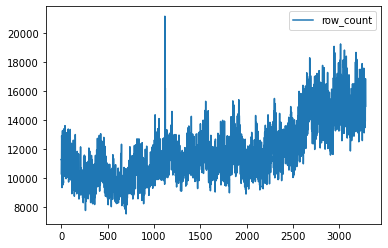

In [25]:
mvp_timeseries.plot()

##### pickle

### drop warning rows

#### Get the warning rows

##### get all the mariadb logs for loading history data

In [9]:
logspath = processed_path + '1-15_load_data_warnings/'
warnpath = processed_path + 'warnrows/'
logs = sorted(os.listdir(warnpath))

##### make dictionary of lists of unique warnings-rownums, one list per log

In [13]:
warnnums = {}
rownum_regex = re.compile(r'(\d*)(?= *\|\n$)')  # (Will get row number from near the end of each record)
for logfile in logs:                            # For each year,
    thislog_warnnums = []                       #  
    with open(logspath + logfile) as log:       # from the warnings for that year
        for line in log.readlines():            # one line at a time
            if re.match(r'^\| Warning \|', line):  # pick the lines that are warnings
                rownum_str = re.search(rownum_regex, line).group()  # find the dumpfile row number
                rownum_int = int(rownum_str)    # make it an integer
                thislog_warnnums.append(rownum_int)  # append to the right list
    warnnums[logfile.split('.')[0]] = list(set(thislog_warnnums))  # remove duplicate row numbers for each year

##### peek

In [11]:
len(warnnums), {i:len(warnnums[i]) for i in warnnums}, pd.Series(warnnums['t2013.log']);

##### output rows list to mariadb

In [16]:
df = pd.DataFrame()
for i in warnnums:
    df = df.append(pd.Series(warnnums[i], name=i))
df = df.T
df = df.convert_dtypes(convert_floating=False)

# run these to create warn_rows
# df.to_sql('warn_rows', conn, index=True)
# conn.execute('ALTER TABLE `warn_rows` ADD PRIMARY KEY (`index`);')

#### make lists of queries

#####  to create table without warning rows

In [43]:
create_clean_history_tables_queries = []
for year in range(2013, 2022):
    create_clean_history_tables_queries.append(

f"""
create table jawiki.h{year} as
(
    select * 
    from jawiki.t{year}
    where jawiki.t{year}.row_id not in
    (
        select jawiki.warn_rows.t{year} 
        from jawiki.warn_rows 
        where jawiki.warn_rows.t{year} is not null
    )
)
;
"""

    )
    

##### print queries

In [24]:
print(create_clean_history_tables_queries[0])


create table jawiki.h2013 as
(
    select * 
    from jawiki.t2013
    where jawiki.t2013.row_id not in
    (
        select jawiki.warn_rows.t2013 
        from jawiki.warn_rows 
        where jawiki.warn_rows.t2013 is not null
    )
    limit 10
)
;



##### to drop all the cleaned history tables

In [27]:
drop_clean_history_tables_queries = []
for year in range(2013, 2022):
    drop_clean_history_tables_queries.append(
f"""
drop table jawiki.h{year};
"""
    )

In [30]:
print(drop_clean_history_tables_queries[0])


drop table jawiki.h2013;



#### run the create tables queries

In [185]:
cxn, cur, engine, conn = connect_mariadb()

## union all years of history tables

#### tests

##### create test version of history table

##### print table

In [ ]:
jpr_sql("""select * from jawiki.history;""")

##### drop table

In [190]:
jpr_sql("""drop table jawiki.history;""")

Printing results error:
This result object does not return rows. It has been closed automatically.
Printing result


#### generate query to create history table as union

In [ ]:
union_query = (
r"""create table jawiki.history as
"""
+
r"""
UNION ALL
""".join([f'(SELECT * FROM h{year})' for year in range(2013,2022)])
+
r"""
;"""
)

##### print

In [179]:
print(union_query)

create table jawiki.history as
(SELECT * FROM h2013 LIMIT 10)
UNION ALL
(SELECT * FROM h2014 LIMIT 10)
UNION ALL
(SELECT * FROM h2015 LIMIT 10)
UNION ALL
(SELECT * FROM h2016 LIMIT 10)
UNION ALL
(SELECT * FROM h2017 LIMIT 10)
UNION ALL
(SELECT * FROM h2018 LIMIT 10)
UNION ALL
(SELECT * FROM h2019 LIMIT 10)
UNION ALL
(SELECT * FROM h2020 LIMIT 10)
UNION ALL
(SELECT * FROM h2021 LIMIT 10)
;


#### run union_query to create union table

# END

## old code, test code

will delete after have used the new code successfully a few more times

###### old query to subset timeseries

In [6]:
sql_old = """
  with formatted_date as (
    select
        STR_TO_DATE(event_timestamp, '%Y-%m-%d %T') as date_tmstp
        ,user_id
        ,user_text
        ,count(row_id) as row_count
        ,page_id
    from h2021
    where 
        page_id in (109, 11, 331)
        and event_entity = 'revision'
        and user_is_bot_by IS NULL
        and event_user_is_bot_by IS NULL
    group by page_id
  )
  
  select
    date(date_tmstp) as day
    ,page_id
    ,row_count
    ,user_id
    ,user_text
  from formatted_date
  group by 1
  order by 1
  ;
"""

###### peek at count of some pages edited with some frequency for testing

In [58]:
high_rev_counts = pd.read_sql("""
    select page_id, count(row_id) as rev_count 
    from h2021 
    where 
        event_entity = 'revision'
        and user_is_bot_by IS NULL
        and event_user_is_bot_by IS NULL
    group by page_id 
    having rev_count > 100 
    limit 10""", conn)

###### X (OLD) str_to_date code

string-to-timestamp-in-mysql [link](https://stackoverflow.com/questions/8587177/string-to-timestamp-in-mysql)

###### select str_to_date test code

In [ ]:
# create table mvp_timeseries as (select " + mvp_cols + r" from h2021 where event_entity = 'revision' limit 20);
jpr_sql("""
SELECT
    STR_TO_DATE(event_timestamp, '%Y-%m-%d %T')
FROM history
;    
""")

In [269]:
jpr_sql("""
SELECT
    LENGTH(event_timestamp), 
    COUNT(*)
FROM h2021
GROUP BY 1
;    
""")

[(21, 6844227)]

In [270]:
jpr_sql("""
SELECT
    event_timestamp
FROM h2021
LIMIT 5
;    
""")

[(bytearray(b'2021-01-01 00:00:00.0'),),
 (bytearray(b'2021-01-01 00:00:00.0'),),
 (bytearray(b'2021-01-01 00:00:01.0'),),
 (bytearray(b'2021-01-01 00:00:01.0'),),
 (bytearray(b'2021-01-01 00:00:01.0'),)]

In [ ]:
jpr_sql("""
SELECT
    STR_TO_DATE(event_timestamp, '%Y-%m-%d %T')
FROM h2021 
;    
""")

##### create table mvp_timeseries

In [248]:
# STR_TO_DATE(event_timestamp, '%Y-%m-%d %T'),

mvp_cols = r"""
event_user_id,
event_user_is_bot_by IS NULL AS event_user_is_human,
page_id,
page_title,
page_namespace,
user_id,
user_text,
user_is_bot_by IS NULL AS user_is_human,
revision_text_bytes,
revision_text_bytes_diff,
row_id
"""

# where event_entity = 'revision'

In [ ]:
jpr_sql('show tables;')

In [266]:
jpr_sql(r"create table mvp_timeseries as (select " + mvp_cols + r" from h2021 where event_entity = 'revision' limit 20);")

Printing execute error:
(mysql.connector.errors.DataError) 1292 (22007): Truncated incorrect datetime value: '2021-01-01 00:00:00.0'
[SQL: create table mvp_timeseries as (select 
STR_TO_DATE(event_timestamp, '%Y-%m-%d %T'),
event_user_id,
event_user_is_bot_by IS NULL AS event_user_is_human,
page_id,
page_title,
page_namespace,
user_id,
user_text,
user_is_bot_by IS NULL AS user_is_human,
revision_text_bytes,
revision_text_bytes_diff,
row_id
 from h2021 where event_entity = 'revision' limit 20);]
(Background on this error at: https://sqlalche.me/e/14/9h9h)


## Stuff to put elsewhere

##### get_flat_list

In [ ]:
import itertools as IT
import collections

def flatten(iterable, ltypes=collections.abc.Iterable):
    """This version of flatten avoids python's recursion limit 
      (and thus works with arbitrarily deep, nested iterables).
      It is a generator which can handle strings and arbitrary iterables 
      (even infinite ones).
    By unutbu:
      https://stackoverflow.com/a/2158562/16133813
    """
    
    remainder = iter(iterable)
    while True:
        first = next(remainder)
        if isinstance(first, ltypes) and not isinstance(first, (str, bytes)):
            remainder = IT.chain(first, remainder)
        else:
            yield first

def get_flat_list(iterable):
    gen = flatten(iterable)
    mylist = []
    still_going = True
    while still_going:
        try:
            next_item = next(gen)
            mylist.append(next_item)
        except Exception as e:
            print(e)
            still_going = False
    return mylist